In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Nadam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
import shutil
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
!pip install -q Augmentor

In [4]:
path_to_training_dataset = '/kaggle/input/skin-cancer-binary-classification-dataset/Skin_Data/'
class_names = ['Cancer','Non_Cancer']
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i + '/Training', output_directory='/kaggle/working/Train/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(4200)

Initialised with 42 image(s) found.
Output directory set to /kaggle/working/Train/Cancer.

Processing <PIL.Image.Image image mode=RGB size=390x350 at 0x7CA8902AFA90>: 100%|██████████| 4200/4200 [01:47<00:00, 38.99 Samples/s]                    


Initialised with 42 image(s) found.
Output directory set to /kaggle/working/Train/Non_Cancer.

Processing <PIL.Image.Image image mode=RGB size=160x140 at 0x7CA898271570>: 100%|██████████| 4200/4200 [00:43<00:00, 95.63 Samples/s]                    


In [5]:
data_dir = '/kaggle/input/skin-cancer-binary-classification-dataset/Skin_Data'  # Update this to your dataset directory
output_dir = '/kaggle/working/'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create subdirectories for train and valid (no test directory)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)


# Define the classes for binary classification
classes = ['Cancer', 'Non_Cancer']

# Move data from source to train/valid folders
for class_name in classes:
    class_dir = os.path.join(data_dir,class_name,"Testing")

    # Create subdirectories for train and valid within each class
    os.makedirs(os.path.join(output_dir, 'test', class_name), exist_ok=True)
#     os.makedirs(os.path.join(output_dir, 'valid', class_name), exist_ok=True)

    # List all files in the current class directory
    files = os.listdir(class_dir)


    # Move files to train
    for file in files:
        source_path = os.path.join(class_dir, file)
        dest_path = os.path.join(output_dir, 'test', class_name, file)
        shutil.copyfile(source_path, dest_path)

print("Data preprocessing for binary classification complete.")

Data preprocessing for binary classification complete.


In [6]:
batch_size = 16
img_height = 180
img_width = 180

In [7]:
output_dir = '/kaggle/working/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8400 files belonging to 2 classes.
Using 6720 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8400 files belonging to 2 classes.
Using 1680 files for validation.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/kaggle/working/test',
  seed=123,
  validation_split = 0.9,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 204 files belonging to 2 classes.
Using 183 files for validation.


In [10]:
input_shape = (img_height,img_width,3)
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=input_shape)])
model.add(Conv2D(16,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(128,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [11]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [12]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2023-10-12 04:21:13.343046: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


420/420 [==============================] - 27s 32ms/step - loss: 0.7669 - accuracy: 0.9378 - val_loss: 5.3300 - val_accuracy: 0.7131
Epoch 2/20
420/420 [==============================] - 14s 34ms/step - loss: 0.3405 - accuracy: 0.9801 - val_loss: 1.1759 - val_accuracy: 0.9470
Epoch 3/20
420/420 [==============================] - 13s 32ms/step - loss: 0.1780 - accuracy: 0.9899 - val_loss: 5.6293 - val_accuracy: 0.8589
Epoch 4/20
420/420 [==============================] - 15s 35ms/step - loss: 0.2465 - accuracy: 0.9885 - val_loss: 12.7086 - val_accuracy: 0.7048
Epoch 5/20
420/420 [==============================] - 14s 33ms/step - loss: 0.0968 - accuracy: 0.9943 - val_loss: 0.3824 - val_accuracy: 0.9685
Epoch 6/20
420/420 [==============================] - 13s 31ms/step - loss: 0.0406 - accuracy: 0.9978 - val_loss: 1.0634 - val_accuracy: 0.9851
Epoch 7/20
420/420 [==============================] - 14s 33ms/step - loss: 0.4887 - accuracy: 0.9887 - val_loss: 5.5921 - val_accuracy: 0.9232
Ep

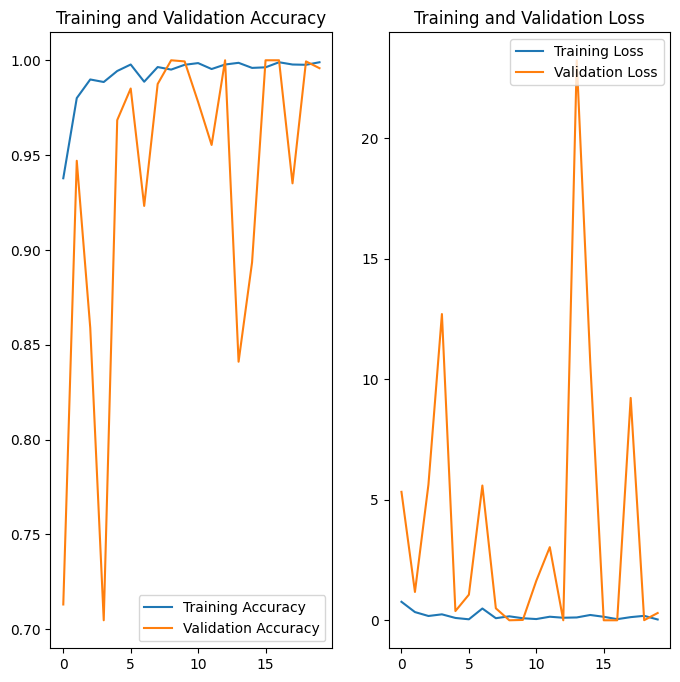

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size)

12/12 [==============================] - 0s 26ms/step - loss: 42.2852 - accuracy: 0.8142


In [15]:
model.save("Binary Cancer 82%acc.h5")

In [16]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [17]:
img = image.load_img('/kaggle/input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Testing/1789-02.JPG',target_size =(180,180))

In [18]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
pred =model.predict(x)
if(float(pred[0]) >= 0.5):
    print("Non Cancer")
else:
    print("Cancer")
score = float(pred[0])
print(f"This image is {100 * (1 - score):.2f}% Cancer and {100 * score:.2f}% Non Cancer.")

1/1 [==============================] - 0s 280ms/step
Cancer
This image is 100.00% Cancer and 0.00% Non Cancer.
